In [19]:
#Import Libraries
import numpy as np
import pandas as pd
import io
from lmfit.models import Pearson7Model, PolynomialModel
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
import os
import re
from ipyfilechooser import FileChooser
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import sys
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from scipy.optimize import root_scalar

In [20]:
#Functions for Data Processing

#Initialize dictionaries and arrays
fitted_data_dict = {}
experiment_info = {}
temp_calib_info = {}

fig_reference = []
fig_high_pressure = []
result_reference = []
result_high_pressure = []
fitted_data_reference = []
fitted_data_high_pressure = []
boxplot_figures = []

# Function to fit Ruby PL data to a Pearson VII model and report and plot the results
def process_file(uploaded_file):
    data = pd.read_csv(io.BytesIO(uploaded_file['content']))
    
    # Extract x and y values
    x = data.iloc[:, 0].values
    y = data.iloc[:, 1].values

    # Define the model: two Pearson VII peaks + 3rd-order polynomial background
    model = (Pearson7Model(prefix='p1_') + 
             Pearson7Model(prefix='p2_') + 
             PolynomialModel(degree=3, prefix='bkg_'))

    # Set initial parameters
    params = model.make_params()

    # Parameters for the first Pearson VII peak
    params['p1_amplitude'].set(value=1e4, min=0)
    params['p1_center'].set(value=694, min=690, max=710)
    params['p1_sigma'].set(value=1, min=0)
    params['p1_expon'].set(value=1.5, min=0)  # q parameter controls the shape (1 = Lorentzian)

    # Parameters for the second Pearson VII peak
    params['p2_amplitude'].set(value=1e4, min=0)
    params['p2_center'].set(value=692, min=690, max=710)
    params['p2_expon'].set(value=2, min=0)

    # Parameters for the 3rd-order polynomial background
    params['bkg_c0'].set(value=np.mean(y), min=0)
    params['bkg_c1'].set(value=0, min=-1e6, max=1e6)
    params['bkg_c2'].set(value=0, min=-1e6, max=1e6)
    params['bkg_c3'].set(value=0, min=-1e6, max=1e6)

    # Fit the model to the data
    result = model.fit(y, params, x=x)

    # Print the fit report
    print(result.fit_report())

    # Extract peak parameters from the fit result
    p1_center = result.params['p1_center'].value
    p2_center = result.params['p2_center'].value

    # Calculate residuals
    residuals = y - result.best_fit

    # Calculate r-squared value
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Create a figure with two subplots: one for the main plot, one for the residuals
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Main plot: data and fit
    ax1.scatter(x, y, label='Data', color='blue', alpha=0.5)
    ax1.plot(x, result.best_fit, label='Best Fit', color='red', linewidth=2)

    # Plot individual components
    components = result.eval_components(x=x)
    ax1.plot(x, components['p1_'], '--', label='Peak 1', color='purple')
    ax1.plot(x, components['p2_'], '--', label='Peak 2', color='orange')
    ax1.plot(x, components['bkg_'], '--', label='Background', color='cyan')

    # Add annotations for peak centers
    idx_p1 = np.argmin(np.abs(x - p1_center))
    idx_p2 = np.argmin(np.abs(x - p2_center))
    ax1.text(x[idx_p1], result.best_fit[idx_p1]*1.02, 
             f'x={p1_center:.3f}', fontsize=11, 
             color='black', ha='left', va='bottom')

    ax1.text(x[idx_p2], result.best_fit[idx_p2]*1.01, 
             f'x={p2_center:.3f}', fontsize=11, 
             color='black', ha='right', va='bottom')

    ax1.set_ylabel('Intensity (counts)')
    ax1.legend()
    ax1.set_title(f'Fit of Two Pearson VII Peaks with 3rd-Order Polynomial Background\nFile: {uploaded_file["name"]}')

    # Set x-axis range
    ax1.set_xlim(p1_center-12,p1_center+15)

    # Residuals plot
    ax2.plot(x, residuals, label='Residuals', color='red', linewidth=1)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Residuals')
    ax2.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    #Extract figure size
    global fig_size
    fig_size = fig.get_size_inches()

    # Store the fitted data in a dictionary for post processing
    fitted_data_dict[uploaded_file['name']] = {
        'x': x,
        'y': result.best_fit,
        'p1_center': p1_center,
        'p1_uncertainty': result.params['p1_center'].stderr if result.params['p1_center'].stderr is not None else 0,
        'p2_center': p2_center,
        'residuals': residuals,
        'r_squared': r_squared,
        'y_raw': y,

    }
    
    # Add an entry to the data dictionary for temperature, T, if one is specified in the file name
    T = {}

    # Iterate through the keys of the fitted_data_dict
    for key in fitted_data_dict.keys():
    # Use regular expression to find the pattern of numbers followed by 'K'
        match = re.search(r'\d+K', key)
        if match:
        # Save the matched pattern as an entry in the dictionary T
            T[key] = match.group()
    
    # Add 'T' to fitted_data_dict
    for key in fitted_data_dict.keys():
        if key in T:
            fitted_data_dict[key]['T'] = T[key]

    # Return fig, result, and fitted_data
    return fig, result, pd.DataFrame({'x': x, 'y': result.best_fit, 'residuals': residuals})


#Save all data -- plots, fit results, and fitted curves -- for each file processed  
def save_all_fitted(uploaded_file, fig, result, fitted_data, uploader_type):
    # Use the global selected_folder_path
    global selected_folder_path
    
    # Determine the folder name based on the uploader type
    if uploader_type == 'reference':
        plot_folder_name = os.path.join(selected_folder_path, 'Fitted Reference Plots')
        results_folder_name = os.path.join(selected_folder_path, 'Fitted Reference Data')
    elif uploader_type == 'high_pressure':
        plot_folder_name = os.path.join(selected_folder_path, 'Fitted HP Plots')
        results_folder_name = os.path.join(selected_folder_path, 'Fitted HP Data')
    else:
        raise ValueError("Unknown uploader type")

    # Create the folders if they don't exist
    if not os.path.exists(plot_folder_name):
        os.makedirs(plot_folder_name)
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name)

    # Save the plot to the folder
    plot_filename = os.path.join(plot_folder_name, f'fit_plot_with_residuals_{uploaded_file["name"]}.png')
    fig.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")

    # Save fit results to a file
    fit_results_filename = os.path.join(results_folder_name, f'fit_results_{uploaded_file["name"]}.txt')
    with open(fit_results_filename, 'w') as f:
        f.write(result.fit_report())
    print(f"Fit results saved to {fit_results_filename}")

    # Save fitted curve to a CSV file
    fitted_curve_filename = os.path.join(results_folder_name, f'fitted_curve_with_residuals_{uploaded_file["name"]}.csv')
    fitted_data.to_csv(fitted_curve_filename, index=False)
    print(f"Fitted curve saved to {fitted_curve_filename}")


# Function to rename keys in the dictionary
def rename_keys(uploader, prefix):
    new_dict = {}
    for i, uploaded_file in enumerate(uploader.value, start=1):
        original_key = uploaded_file['name']
        fitted_data_dict[original_key]['filename'] = original_key
        new_key = f"{prefix}_{i}"
        new_dict[new_key] = fitted_data_dict.pop(uploaded_file['name'])
    fitted_data_dict.update(new_dict)


# Function to calculate the average p1_center and uncertainty for reference and high pressure data
def avg_and_propagate_uncertainty(fitted_data_dict):
    reference_p1_centers = []
    reference_p1_uncertainties = []
    high_pressure_p1_centers = []
    high_pressure_p1_uncertainties = []

    for key, value in fitted_data_dict.items():
        if 'reference' in key:
            reference_p1_centers.append(value['p1_center'])
            reference_p1_uncertainties.append(value['p1_uncertainty'])
        elif 'high_pressure' in key:
            high_pressure_p1_centers.append(value['p1_center'])
            high_pressure_p1_uncertainties.append(value['p1_uncertainty'])

    # Calculate the average p1_center for reference and high pressure
    average_p1_center_reference = np.mean(reference_p1_centers) if reference_p1_centers else None
    average_p1_center_high_pressure = np.mean(high_pressure_p1_centers) if high_pressure_p1_centers else None

    # Calculate the uncertainty in the average p1_center for reference and high pressure
    uncertainty_p1_center_reference = np.sqrt(np.sum(np.array(reference_p1_uncertainties)**2)) / len(reference_p1_uncertainties) if reference_p1_uncertainties else None
    uncertainty_p1_center_high_pressure = np.sqrt(np.sum(np.array(high_pressure_p1_uncertainties)**2)) / len(high_pressure_p1_uncertainties) if high_pressure_p1_uncertainties else None

    return (average_p1_center_reference, uncertainty_p1_center_reference), (average_p1_center_high_pressure, uncertainty_p1_center_high_pressure)


# Function to perform the pressure calibration and propagate uncertainty from R1 peak locations
def avg_pressure_calibration(average_p1_center_reference, uncertainty_p1_center_reference, average_p1_center_high_pressure, uncertainty_p1_center_high_pressure):

    # Constants from Mao et al. (1986)
    A = 19.04
    B = 7.665

    # Calculate the pressure calibration in Mbar
    pressure_calibration_Mbar = (A / B) * (((average_p1_center_high_pressure / average_p1_center_reference) ** B) - 1)

    # Calculate the partial derivatives
    partial_derivative_reference = -(A / B) * B * ((average_p1_center_high_pressure / average_p1_center_reference) ** B) / average_p1_center_reference
    partial_derivative_high_pressure = (A / B) * B * ((average_p1_center_high_pressure / average_p1_center_reference) ** (B - 1)) / average_p1_center_reference

    # Calculate the propagated uncertainty
    propagated_uncertainty_Mbar = np.sqrt(
        (partial_derivative_reference * uncertainty_p1_center_reference) ** 2 +
        (partial_derivative_high_pressure * uncertainty_p1_center_high_pressure) ** 2
    )

    # Convert the pressure calibration and uncertainty to GPa and MPa
    pressure_calibration_GPa = pressure_calibration_Mbar * 100
    propagated_uncertainty_GPa = propagated_uncertainty_Mbar * 100
    pressure_calibration_MPa = pressure_calibration_GPa * 1000
    propagated_uncertainty_MPa = propagated_uncertainty_GPa * 1000

    # Report uncertainty in scientific notation
    propagated_uncertainty_GPa_sci = format(propagated_uncertainty_GPa, '.2e')
    propagated_uncertainty_MPa_rounded = round(propagated_uncertainty_MPa, 2)

    print(f"Pressure calibration: {pressure_calibration_GPa:.2f} ± {propagated_uncertainty_GPa_sci} GPa")
    print(f"Pressure calibration: {pressure_calibration_MPa:.2f} ± {propagated_uncertainty_MPa_rounded} MPa")

    return pressure_calibration_GPa, propagated_uncertainty_GPa, pressure_calibration_MPa, propagated_uncertainty_MPa


# Function to match and report all R1 peak locations and uncertainties
def raw_data_table(fitted_data_dict):
    reference_keys = [key for key in fitted_data_dict.keys() if 'reference' in key]
    high_pressure_keys = [key for key in fitted_data_dict.keys() if 'high_pressure' in key]

    # Initialize an empty DataFrame with reference keys as rows and high pressure keys as columns
    fitted_data_table = pd.DataFrame(index=reference_keys, columns=high_pressure_keys)

    # Populate the DataFrame with p1_center and p1_uncertainty values
    for ref_key in reference_keys:
        for hp_key in high_pressure_keys:
            p1_center_ref = fitted_data_dict[ref_key]['p1_center']
            p1_uncertainty_ref = fitted_data_dict[ref_key]['p1_uncertainty']
            p1_center_hp = fitted_data_dict[hp_key]['p1_center']
            p1_uncertainty_hp = fitted_data_dict[hp_key]['p1_uncertainty']
            fitted_data_table.loc[ref_key, hp_key] = f"({p1_center_ref:.6f}, {p1_uncertainty_ref:.6e}), ({p1_center_hp:.6f}, {p1_uncertainty_hp:.6e})"

    return fitted_data_table


# Function to perform pressure calibration and propagate uncertainty from R1 Pearson VII Fitting
def single_pressure_calibration(fitted_data_dict):
    # Generate the fitted data table using the raw_data_table function
    fitted_data_table = raw_data_table(fitted_data_dict)
    
    # Constants from Mao et al. (1986)
    A = 19.04
    B = 7.665

    # Iterate over the DataFrame and calculate pressure calibration for each pair of reference and high pressure data
    pressure_calibration_results = {}

    for ref_key in fitted_data_table.index:
        for hp_key in fitted_data_table.columns:
            ref_data = fitted_data_table.loc[ref_key, hp_key]
            ref_p1_center, ref_p1_uncertainty = map(float, ref_data.split('), (')[0].strip('()').split(', '))
            hp_p1_center, hp_p1_uncertainty = map(float, ref_data.split('), (')[1].strip('()').split(', '))

            # Calculate the pressure calibration in Mbar
            pressure_calibration_Mbar = (A / B) * (((hp_p1_center / ref_p1_center) ** B) - 1)

            # Calculate the partial derivatives
            partial_derivative_reference = -(A / B) * B * ((hp_p1_center / ref_p1_center) ** B) / ref_p1_center
            partial_derivative_high_pressure = (A / B) * B * ((hp_p1_center / ref_p1_center) ** (B - 1)) / ref_p1_center

            # Calculate the propagated uncertainty only if both uncertainties are non-zero
            if ref_p1_uncertainty != 0 and hp_p1_uncertainty != 0:
                propagated_uncertainty_Mbar = np.sqrt(
                    (partial_derivative_reference * ref_p1_uncertainty) ** 2 +
                    (partial_derivative_high_pressure * hp_p1_uncertainty) ** 2
                )
                propagated_uncertainty_GPa = propagated_uncertainty_Mbar * 100
                propagated_uncertainty_MPa = propagated_uncertainty_GPa * 1000
            else:
                propagated_uncertainty_GPa = 0
                propagated_uncertainty_MPa = 0

            # Convert the pressure calibration to GPa and MPa
            pressure_calibration_GPa = pressure_calibration_Mbar * 100
            pressure_calibration_MPa = pressure_calibration_GPa * 1000

            # Store the results in a dictionary
            pressure_calibration_results[(ref_key, hp_key)] = {
                'pressure_calibration_GPa': pressure_calibration_GPa,
                'propagated_uncertainty_GPa': propagated_uncertainty_GPa,
                'pressure_calibration_MPa': pressure_calibration_MPa,
                'propagated_uncertainty_MPa': propagated_uncertainty_MPa
            }

    return pressure_calibration_results


def bulk_pressure_calibration_boxplot(fitted_data_dict):
    global boxplot_figures

    # Produce data for plot based on uploaded files post fitting
    pressure_calibration_results = single_pressure_calibration(fitted_data_dict)

    # Extract the pressure calibration values in MPa and their uncertainties
    pressure_values = [values['pressure_calibration_MPa'] for values in pressure_calibration_results.values()]
    uncertainties = [values['propagated_uncertainty_MPa'] for values in pressure_calibration_results.values()]

    # Calculate the median and mean of the pressure values
    median_pressure = np.median(pressure_values)
    average_pressure_GPa, propagated_uncertainty_GPa, average_pressure_MPa, propagated_uncertainty_MPa = bulk_pressure_calibration(pressure_calibration_results)

    # Find the uncertainty associated with the median pressure
    if median_pressure in pressure_values:
        median_index = pressure_values.index(median_pressure)
        median_uncertainty = uncertainties[median_index]
    else:
        median_uncertainty = 0

    # Remove the mean and median values from the pressure values and uncertainties
    pressure_values_without_median = [value for value in pressure_values if value != median_pressure]
    uncertainties_without_median = [uncertainties[i] for i in range(len(pressure_values)) if pressure_values[i] != median_pressure]

    # Create a box plot with all data
    fig_boxplot, ax = plt.subplots(figsize=(10, 6))
    fig_boxplot.set_size_inches(fig_size[0], fig_size[1])
    ax.boxplot(pressure_values, vert=True, patch_artist=True, showmeans=True, showfliers=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                medianprops=dict(color='blue'),
                meanprops=dict(marker='o', markerfacecolor='green', markeredgecolor='black'),
                flierprops=dict(marker='o', color='orange', alpha=0.5))

    # Overlay the pressure values as points with error bars excluding the mean and median
    ax.errorbar([1] * len(pressure_values_without_median), pressure_values_without_median, yerr=uncertainties_without_median, fmt='o', color='black', ecolor='gray', capsize=5)

    # Plot the mean and median as individual points
    if all(uncertainty > 0 for uncertainty in uncertainties):
        ax.plot(1, median_pressure, 'bo', label=f'Median: {median_pressure:.2f} ± {median_uncertainty:.2f} MPa')
        ax.plot(1, average_pressure_MPa, 'go', label=f'Mean: {average_pressure_MPa:.2f} ± {propagated_uncertainty_MPa:.2f} MPa')
        ax.errorbar(1, median_pressure, yerr=median_uncertainty, fmt='o', color='blue', ecolor='gray', capsize=5)
        ax.errorbar(1, average_pressure_MPa, yerr=propagated_uncertainty_MPa, fmt='o', color='green', ecolor='gray', capsize=5)
    elif median_uncertainty > 0 and any(uncertainty == 0 for uncertainty in uncertainties):
        ax.plot(1, median_pressure, 'bo', label=f'Median: {median_pressure:.2f} ± {median_uncertainty:.2f} MPa')
        ax.plot(1, average_pressure_MPa, 'go', label=f'Mean: {average_pressure_MPa:.2f} ± N/A MPa')
        ax.errorbar(1, median_pressure, yerr=median_uncertainty, fmt='o', color='blue', ecolor='gray', capsize=5)
    elif median_uncertainty == 0 and all(uncertainty > 0 for uncertainty in uncertainties):
        ax.plot(1, median_pressure, 'bo', label=f'Median: {median_pressure:.2f} ± N/A MPa')
        ax.plot(1, average_pressure_MPa, 'go', label=f'Mean: {average_pressure_MPa:.2f} ± {propagated_uncertainty_MPa:.2f} MPa')
        ax.errorbar(1, average_pressure_MPa, yerr=propagated_uncertainty_MPa, fmt='o', color='green', ecolor='gray', capsize=5)
    else:
        ax.plot(1, median_pressure, 'bo', label=f'Median: {median_pressure:.2f} ± N/A MPa')
        ax.plot(1, average_pressure_MPa, 'go',  label=f'Mean: {average_pressure_MPa:.2f} ± N/A MPa')

    pressure_values = [values['pressure_calibration_MPa'] for values in pressure_calibration_results.values()]
    min_pressure = round(min(pressure_values), 2)
    max_pressure = round(max(pressure_values), 2)

    # Set the x-axis label based on the temperature entry in experiment_info
    temperature = experiment_info.get('Temperature (K)', '')
    if temperature:
        ax.set_xlabel(f"Pressure Calibration Data at {temperature} K")
    else:
        ax.set_xlabel("Pressure Calibration Data")

    ax.set_title("Pressure Calibration Results: {} to {} MPa".format(min_pressure, max_pressure))
    ax.set_ylabel('Pressure (MPa)')
    ax.grid(True)

    # Add legend for median and mean
    ax.legend(loc='upper right')

    # Add a third legend for temperature calibration information within the plot area
    temp_calib_info_text = ""
    if temp_calib_info.get("Polynomial Temperature Calibration"):
        # Show polynomial equation if polynomial correction is performed
        temp_calib_info_text += "Polynomial Temperature Calibration: Performed\n"
        temp_calib_info_text += f"ΔT = ({temp_corr_poly_a:.2e})·T² + ({temp_corr_poly_b:.2e})·T + ({temp_corr_poly_c:.2f})\n"
    elif temp_calib_info.get("Two-point Temperature Calibration"):
        temp_calib_info_text += "Two-point Temperature Calibration: Performed\n"
        temp_calib_info_text += f"Freezing Point (K): {temp_calib_info.get('Freezing Point (K)', '')}\n"
        temp_calib_info_text += f"Boiling Point (K): {temp_calib_info.get('Boiling Point (K)', '')}\n"

    if temp_calib_info_text != "":
        num_lines = temp_calib_info_text.count('\n') + 1
        vertical_position = (num_lines * 0.05)
        ax.text(0.98, vertical_position, temp_calib_info_text, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
        ax.text(0.98, vertical_position + 0.05, "Temperature Calibration Info", transform=ax.transAxes, fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='right')
    else:
        vertical_position = 0

    # Add a second legend for experiment information within the plot area
    experiment_info_text = "\n".join([f"{key}: {value}" for key, value in experiment_info.items() if key != 'Temperature (K)' and value])
    if experiment_info_text != "":
        num_lines = experiment_info_text.count('\n') + 1
        vertical_position += (num_lines * 0.05) + 0.05
        ax.text(0.98, vertical_position, experiment_info_text, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
        ax.text(0.98, vertical_position + 0.05, "Experimental Info", transform=ax.transAxes, fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='right')

    # Check if the title is unique before adding the figure to boxplot_figures
    titles = [fig.axes[0].get_title() for fig in boxplot_figures]
    if ax.get_title() not in titles:
        boxplot_figures.append(fig_boxplot)
        print("Box plot has been stored.")
    else:
        index = titles.index(ax.get_title())
        boxplot_figures[index] = fig_boxplot
        print("Box plot with this title has been replaced.")

    plt.xticks([])

    return fig_boxplot

# Function to produce a data table for all plotted R1 peak locations and uncertainties -- accompanies box plot
def clean_R1_data_table(fitted_data_dict):
    reference_keys = [key for key in fitted_data_dict.keys() if 'reference' in key]
    high_pressure_keys = [key for key in fitted_data_dict.keys() if 'high_pressure' in key]

    # Initialize an empty DataFrame with reference keys as rows and high pressure keys as columns
    cleaned_R1_data_table = pd.DataFrame(index=reference_keys, columns=high_pressure_keys)

    # Populate the DataFrame with p1_center and p1_uncertainty values
    for ref_key in reference_keys:
        for hp_key in high_pressure_keys:
            p1_center_ref = round(fitted_data_dict[ref_key]['p1_center'], 3)
            p1_uncertainty_ref = "{:.2e}".format(fitted_data_dict[ref_key]['p1_uncertainty'])
            p1_center_hp = round(fitted_data_dict[hp_key]['p1_center'], 3)
            p1_uncertainty_hp = "{:.2e}".format(fitted_data_dict[hp_key]['p1_uncertainty'])

            if fitted_data_dict[ref_key]['p1_uncertainty'] > 0 and fitted_data_dict[hp_key]['p1_uncertainty'] > 0:
                cleaned_R1_data_table.loc[ref_key, hp_key] = f"({p1_center_ref:.3f}, {p1_uncertainty_ref}), ({p1_center_hp:.3f}, {p1_uncertainty_hp})"
            elif fitted_data_dict[ref_key]['p1_uncertainty'] > 0 and fitted_data_dict[hp_key]['p1_uncertainty'] == 0:
                cleaned_R1_data_table.loc[ref_key, hp_key] = f"({p1_center_ref:.3f}, {p1_uncertainty_ref}), ({p1_center_hp:.3f})"
            elif fitted_data_dict[ref_key]['p1_uncertainty'] == 0 and fitted_data_dict[hp_key]['p1_uncertainty'] > 0:
                cleaned_R1_data_table.loc[ref_key, hp_key] = f"({p1_center_ref:.3f}), ({p1_center_hp:.3f}, {p1_uncertainty_hp})"
            else:
                cleaned_R1_data_table.loc[ref_key, hp_key] = f"({p1_center_ref:.3f}), ({p1_center_hp:.3f})"

    return cleaned_R1_data_table


# Function to produce a data table for all single pressure calibration results -- accompanies box plot
def clean_pressure_calibration_table(fitted_data_dict):

    # Access the pressure calibration results
    pressure_calibration_results = single_pressure_calibration(fitted_data_dict)

    # Initialize an empty DataFrame with reference keys as rows and high pressure keys as columns
    reference_keys = [key[0] for key in pressure_calibration_results.keys()]
    high_pressure_keys = [key[1] for key in pressure_calibration_results.keys()]
    reference_keys = list(set(reference_keys))
    high_pressure_keys = list(set(high_pressure_keys))
    
    cleaned_pressure_calibration_table = pd.DataFrame(index=reference_keys, columns=high_pressure_keys)

    # Populate the DataFrame with pressure calibration and propagated uncertainty values
    for (ref_key, hp_key), values in pressure_calibration_results.items():
        pressure_calibration_GPa = values['pressure_calibration_GPa']
        propagated_uncertainty_GPa = values['propagated_uncertainty_GPa']
        pressure_calibration_MPa = values['pressure_calibration_MPa']
        propagated_uncertainty_MPa = values['propagated_uncertainty_MPa']
        
        if propagated_uncertainty_GPa > 0:
            cleaned_pressure_calibration_table.loc[ref_key, hp_key] = (f"({pressure_calibration_GPa:.2f}, {propagated_uncertainty_GPa:.2e}) GPa, "
                                                                       f"({pressure_calibration_MPa:.2f}, {propagated_uncertainty_MPa:.2f}) MPa")
        else:
            cleaned_pressure_calibration_table.loc[ref_key, hp_key] = (f"{pressure_calibration_GPa:.2f} GPa, "
                                                                       f"{pressure_calibration_MPa:.2f} MPa")

    return cleaned_pressure_calibration_table


# Function to create data tables for R1 peak locations and pressure calibrations
def box_plot_data_tables(fitted_data_dict):
    #Proivde accompanying data tables for R1 peak locations and pressure calibrations
    cleaned_R1_data_table = clean_R1_data_table(fitted_data_dict)
    cleaned_pressure_calibration_table = clean_pressure_calibration_table(fitted_data_dict)

    # Create a mapping from keys to filenames
    key_to_filename = {key: value['filename'] for key, value in fitted_data_dict.items()}

    # Update the row and column labels for cleaned_R1_data_table
    cleaned_R1_data_table.index = [key_to_filename[key] for key in cleaned_R1_data_table.index]
    cleaned_R1_data_table.columns = [key_to_filename[key] for key in cleaned_R1_data_table.columns]

    # Update the row and column labels for cleaned_pressure_calibration_table
    cleaned_pressure_calibration_table.index = [key_to_filename[key] for key in cleaned_pressure_calibration_table.index]
    cleaned_pressure_calibration_table.columns = [key_to_filename[key] for key in cleaned_pressure_calibration_table.columns]

    # Store both data tables in a dictionary
    data_tables = {
        'R1 Values': cleaned_R1_data_table,
        'Pressure Calibrations': cleaned_pressure_calibration_table
    }

    return data_tables


# Function to replace row and column headers for tables with reference and high_pressure keys from fitted_data_dict
def update_table_headers_and_add_filename_table(fitted_data_dict):

    data_tables = box_plot_data_tables(fitted_data_dict)

    # Create a mapping from keys to filenames
    key_to_filename = {key: value['filename'] for key, value in fitted_data_dict.items()}

    # Update the row and column labels for cleaned_R1_data_table
    data_tables['R1 Values'].index = [key for key in data_tables['R1 Values'].index]
    data_tables['R1 Values'].columns = [key for key in data_tables['R1 Values'].columns]

    # Update the row and column labels for cleaned_pressure_calibration_table
    data_tables['Pressure Calibrations'].index = [key for key in data_tables['Pressure Calibrations'].index]
    data_tables['Pressure Calibrations'].columns = [key for key in data_tables['Pressure Calibrations'].columns]

    # Create a separate table that specifies the file name associated with each key
    filename_table = pd.DataFrame(list(key_to_filename.items()), columns=['Key', 'Filename'])

    # Add the filename table to the data_tables dictionary
    data_tables['Filename Mapping'] = filename_table

    # Create a reverse mapping from filename to key
    filename_to_key = {v: k for k, v in key_to_filename.items()}

    # Update the row and column labels for R1 Values table
    data_tables['R1 Values'].index = [filename_to_key[filename] for filename in data_tables['R1 Values'].index]
    data_tables['R1 Values'].columns = [filename_to_key[filename] for filename in data_tables['R1 Values'].columns]

    # Update the row and column labels for Pressure Calibrations table
    data_tables['Pressure Calibrations'].index = [filename_to_key[filename] for filename in data_tables['Pressure Calibrations'].index]
    data_tables['Pressure Calibrations'].columns = [filename_to_key[filename] for filename in data_tables['Pressure Calibrations'].columns]

    return data_tables


#Function to calculate the average pressure calibration and uncertainty across all single pressure calibration results
def bulk_pressure_calibration(pressure_calibration_results):
    # Initialize lists to store pressure calibration values and uncertainties
    pressure_calibration_GPa_values = []
    propagated_uncertainty_GPa_values = []

    # Iterate over the pressure calibration results and extract values
    for values in pressure_calibration_results.values():
        pressure_calibration_GPa_values.append(values['pressure_calibration_GPa'])
        propagated_uncertainty_GPa_values.append(values['propagated_uncertainty_GPa'])

    # Calculate the average pressure calibration in GPa
    average_pressure_calibration_GPa = np.mean(pressure_calibration_GPa_values)

    # Calculate the propagated uncertainty for the average pressure calibration in GPa
    propagated_uncertainty_GPa = np.sqrt(np.sum(np.array(propagated_uncertainty_GPa_values)**2)) / len(propagated_uncertainty_GPa_values)

    # Convert the average pressure calibration and uncertainty to MPa
    average_pressure_calibration_MPa = average_pressure_calibration_GPa * 1000
    propagated_uncertainty_MPa = propagated_uncertainty_GPa * 1000

    return average_pressure_calibration_GPa, propagated_uncertainty_GPa, average_pressure_calibration_MPa, propagated_uncertainty_MPa


# Function to save the box plot and data tables
def save_box_plot(boxplot_figures, selected_folder_path):
    # Create the folder for box plots if it doesn't exist
    box_plot_folder = os.path.join(selected_folder_path, 'Box Plots')
    if not os.path.exists(box_plot_folder):
        os.makedirs(box_plot_folder)

    # Save each new box plot as a PNG file with the title as the filename
    box_plot_filenames = []
    saved_titles = set()
    for fig_boxplot in boxplot_figures:
        title = fig_boxplot.axes[0].get_title()
        sanitized_title = re.sub(r'[^\w\s-]', '', title).strip().replace(' ', '_')
        if sanitized_title in saved_titles:
            continue
        box_plot_filename = os.path.join(box_plot_folder, f'{sanitized_title}.png')

        # Ensure the filename is unique
        counter = 1
        while os.path.exists(box_plot_filename):
            box_plot_filename = os.path.join(box_plot_folder, f'{sanitized_title}_{counter}.png')
            counter += 1

        # Check if the filename has a counter
        if counter > 1:
            print(f"Skipping box plot with filename: {box_plot_filename}")
            continue

        fig_boxplot.savefig(box_plot_filename)
        box_plot_filenames.append(box_plot_filename)
        saved_titles.add(sanitized_title)
        print(f"Box plot saved to {box_plot_filename}")
    
    return box_plot_filenames


# Function to save the data tables and average pressure calibration to a csv file
def save_data_tables_and_avg_pressure(data_tables, fitted_data_dict, selected_folder_path, box_plot_filenames):
    # Create the folder for saving the data if it doesn't exist
    data_folder = os.path.join(selected_folder_path, 'R1 and Pressure Calibration Data Tables')
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    # Save the data tables and average pressure calibration to the csv file
    for box_plot_filename in box_plot_filenames:
        csv_filename = os.path.join(data_folder, f'{os.path.basename(box_plot_filename).replace(".png", ".csv")}')

        # Check if the filename has a counter
        if re.search(r'_\d+\.csv$', csv_filename):
            print(f"Skipping data table with filename: {csv_filename}")
            continue

        # Calculate the average pressure calibration
        pressure_calibration_results = single_pressure_calibration(fitted_data_dict)
        average_pressure_calibration_GPa, propagated_uncertainty_GPa, average_pressure_calibration_MPa, propagated_uncertainty_MPa = bulk_pressure_calibration(pressure_calibration_results)

        uncertainties = [values['propagated_uncertainty_MPa'] for values in pressure_calibration_results.values()]

        with open(csv_filename, 'w') as f:
            for table_name, table in data_tables.items():
                f.write(f"\n{table_name}:\n")
                table.to_csv(f, index=True)
                f.write("\n\n")
            
            if all(uncertainty > 0 for uncertainty in uncertainties):
                avg_pressure_calibration_str = (f"\nAverage Pressure Calibration: "
                                                f"{average_pressure_calibration_MPa:.2f} ± "
                                                f"{propagated_uncertainty_MPa:.2f} MPa\n")
                f.write(avg_pressure_calibration_str)
            else:
                pass

        print(f"Data tables and average pressure calibration saved to {csv_filename}")


# Function to adjust fitting parameters to ensure high accuracy of fit for Ruby PL
def check_fit(fitted_data_dict):
    all_fitted_properly = True
    for key, value in fitted_data_dict.items():
        if value['r_squared'] < 0.95 or value['p1_center'] <= value['p2_center']:
            all_fitted_properly = False
            print(f"Re-fitting {key} due to low r_squared: {value['r_squared']:.4f} or p1_center <= p2_center")
            while value['r_squared'] < 0.95 or value['p1_center'] <= value['p2_center']:
                x = value['x']
                y = value['y_raw']

                # Define the model: two Pearson VII peaks + 3rd-order polynomial background
                model = (Pearson7Model(prefix='p1_') + 
                         Pearson7Model(prefix='p2_') + 
                         PolynomialModel(degree=3, prefix='bkg_'))

                # Set initial parameters
                params = model.make_params()

                # Parameters for the first Pearson VII peak
                params['p1_amplitude'].set(value=2e4, min=0)
                params['p1_center'].set(value=694, min=690, max=710)
                params['p1_sigma'].set(value=1, min=0)
                params['p1_expon'].set(value=1.5, min=0)  # q parameter controls the shape (1 = Lorentzian)

                # Parameters for the second Pearson VII peak
                params['p2_amplitude'].set(value=2e4, min=0)
                params['p2_center'].set(value=692, min=690, max=710)
                params['p2_expon'].set(value=2, min=0)

                # Parameters for the 3rd-order polynomial background
                params['bkg_c0'].set(value=np.mean(y), min=0)
                params['bkg_c1'].set(value=0, min=-1e6, max=1e6)
                params['bkg_c2'].set(value=0, min=-1e6, max=1e6)
                params['bkg_c3'].set(value=0, min=-1e6, max=1e6)

                # Fit the model to the data
                result = model.fit(y, params, x=x)

                # Print the fit report
                print(result.fit_report())

                # Extract peak parameters from the fit result
                p1_center = result.params['p1_center'].value
                p2_center = result.params['p2_center'].value

                # Check if p1_center is not greater than p2_center
                if p1_center <= p2_center:
                    params['p2_center'].set(max=693)

                # Calculate residuals
                residuals = y - result.best_fit

                # Calculate r-squared value
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                r_squared = 1 - (ss_res / ss_tot)

                # Plot the data and fit
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

                # Main plot: data and fit
                ax1.scatter(x, y, label='Data', color='blue', alpha=0.5)
                ax1.plot(x, result.best_fit, label='Best Fit', color='red', linewidth=2)

                # Plot individual components
                components = result.eval_components(x=x)
                ax1.plot(x, components['p1_'], '--', label='Peak 1', color='purple')
                ax1.plot(x, components['p2_'], '--', label='Peak 2', color='orange')
                ax1.plot(x, components['bkg_'], '--', label='Background', color='cyan')

                # Add annotations for peak centers
                idx_p1 = np.argmin(np.abs(x - p1_center))
                idx_p2 = np.argmin(np.abs(x - p2_center))
                ax1.text(x[idx_p1], result.best_fit[idx_p1]*1.02, 
                         f'x={p1_center:.3f}', fontsize=11, 
                         color='black', ha='left', va='bottom')

                ax1.text(x[idx_p2], result.best_fit[idx_p2]*1.01, 
                         f'x={p2_center:.3f}', fontsize=11, 
                         color='black', ha='right', va='bottom')

                ax1.set_ylabel('Intensity (counts)')
                ax1.legend()
                ax1.set_title(f'Fit of Two Pearson VII Peaks with 3rd-Order Polynomial Background\nFile: {key}')

                # Set x-axis range
                ax1.set_xlim(p1_center-12,p1_center+15)

                # Residuals plot
                ax2.plot(x, residuals, label='Residuals', color='red', linewidth=1)
                ax2.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
                ax2.set_xlabel('Wavelength (nm)')
                ax2.set_ylabel('Residuals')
                ax2.legend()

                # Adjust layout to prevent overlap
                plt.tight_layout()

                # Display the plot interactively
                plt.show()

                # Close the plot to free up memory
                plt.close()

                if r_squared < 0.95 or p1_center <= p2_center:
                    # Increase the amplitude parameters
                    params['p1_amplitude'].set(value=params['p1_amplitude'].value + 1e4)
                    params['p2_amplitude'].set(value=params['p2_amplitude'].value + 1e4)
                else:
                    # Update the fitted data in the dictionary
                    fitted_data_dict[key].update({
                        'y': result.best_fit,
                        'p1_center': p1_center,
                        'p1_uncertainty': result.params['p1_center'].stderr if result.params['p1_center'].stderr is not None else 0,
                        'p2_center': p2_center,
                        'residuals': residuals,
                        'r_squared': r_squared,
                    })

                    #Update fits to be saved -- in conjuction with process_file and save_all_fitted functions
                    if 'reference' in key:
                        index = int(key.split('_')[-1]) - 1
                        fig_reference[index] = fig
                        result_reference[index] = result
                        fitted_data_reference[index] = pd.DataFrame({'x': x, 'y': result.best_fit, 'residuals': residuals})
                    elif 'high_pressure' in key:
                        index = int(key.split('_')[-1]) - 1
                        fig_high_pressure[index] = fig
                        result_high_pressure[index] = result
                        fitted_data_high_pressure[index] = pd.DataFrame({'x': x, 'y': result.best_fit, 'residuals': residuals})

                    print(f"Re-fitted {key} with new r_squared: {r_squared:.4f}")
    if all_fitted_properly:
        print("All files are properly fitted")


#Function to perform temperature calibration for thermocouples based on experimentally measured freezing and boiling points of pure water
def temperature_calibration(freezing_temp, boiling_temp, raw_temp):
    # Literature values for water
    freezing_temp_lit = 273.15  # K
    boiling_temp_lit = 373.15   # K

    # Calculate the slope and intercept for the calibration line
    slope = (boiling_temp_lit - freezing_temp_lit) / (boiling_temp - freezing_temp)
    intercept = freezing_temp_lit - slope * freezing_temp

    # Calibrate the raw temperature
    calibrated_temp = slope * raw_temp + intercept

    # Format the calibrated temperature to 2 decimal places
    calibrated_temp = round(calibrated_temp, 2)
    
    # Plot the calibration line and the literature line
    #plt.figure(figsize=(10, 6))
    
    # Plot the calibration line
    #plt.plot([freezing_temp, boiling_temp], [freezing_temp_lit, boiling_temp_lit], label='Calibration Line', color='blue')
    
    # Plot the literature line
    #plt.plot([freezing_temp_lit, boiling_temp_lit], [freezing_temp_lit, boiling_temp_lit], label='Literature Line', color='red', linestyle='--')
    
    # Plot the raw temperature point
    #plt.scatter(raw_temp, calibrated_temp, color='green', label=f'Raw Temp: {raw_temp}K\nCalibrated Temp: {calibrated_temp:.2f}K')
    
    #plt.xlabel('Raw Temperature (K)')
    #plt.ylabel('Real Temperature (K)')
    #plt.title('Temperature Calibration')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    return calibrated_temp


# Global coefficients for temp_corr_poly
global temp_corr_poly_a, temp_corr_poly_b, temp_corr_poly_c
temp_corr_poly_a = -1.26e-04
temp_corr_poly_b = 5.33e-02
temp_corr_poly_c = -2.95

def temp_corr_poly(raw_temp):
    """
    Apply a temperature correction based on the input polynomial function.

    Uses global coefficients temp_corr_poly_a, temp_corr_poly_b, temp_corr_poly_c.
    Change global coefficients to adjust the polynomial correction.

    Returns:
    Corrected temperature.
    """
    temperature = np.array(raw_temp)
    delta_T = temp_corr_poly_a * temperature**2 + temp_corr_poly_b * temperature + temp_corr_poly_c
    calibrated_temp = temperature + delta_T
    calibrated_temp = round(calibrated_temp, 2)
    return calibrated_temp



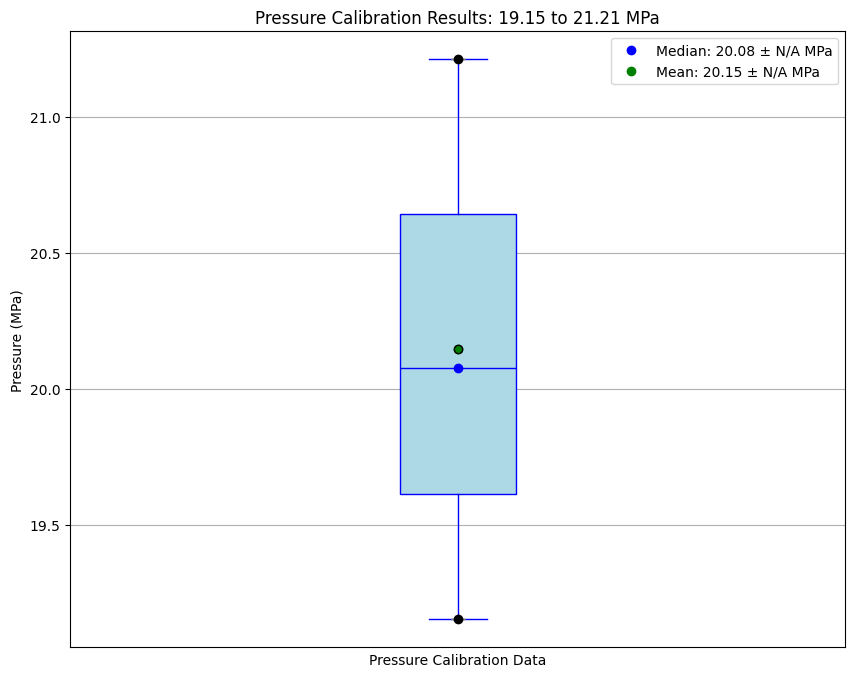

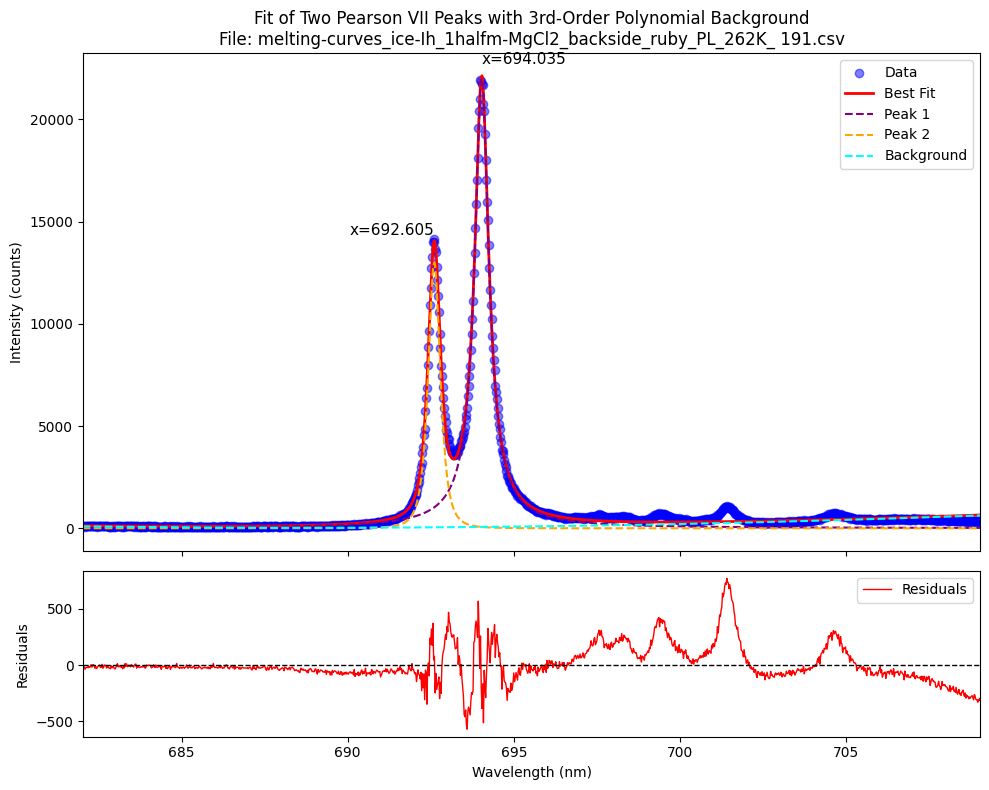

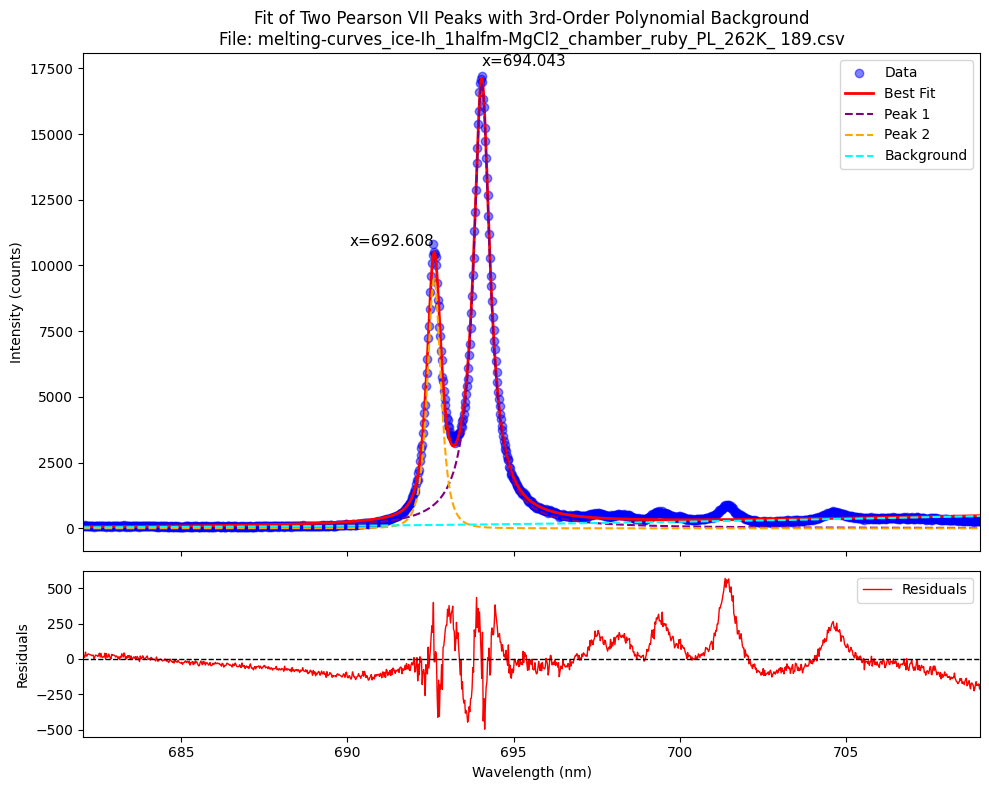

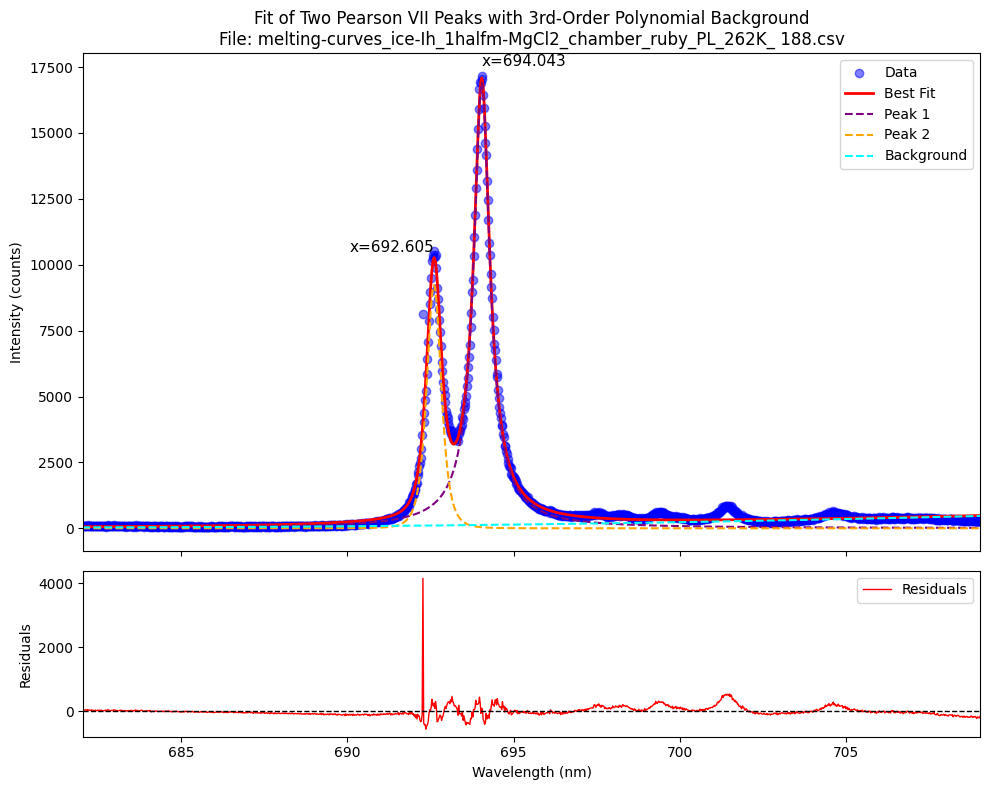

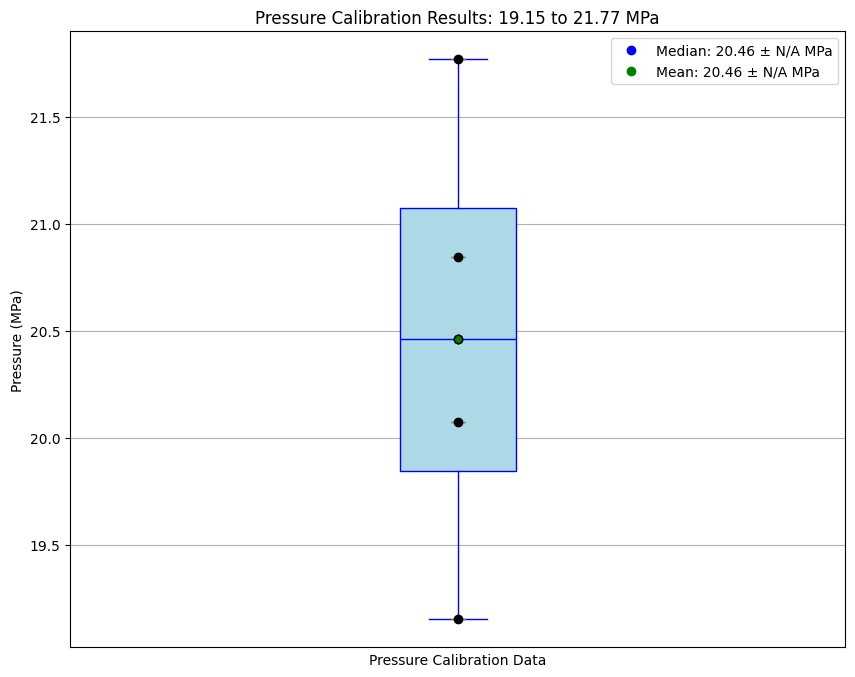

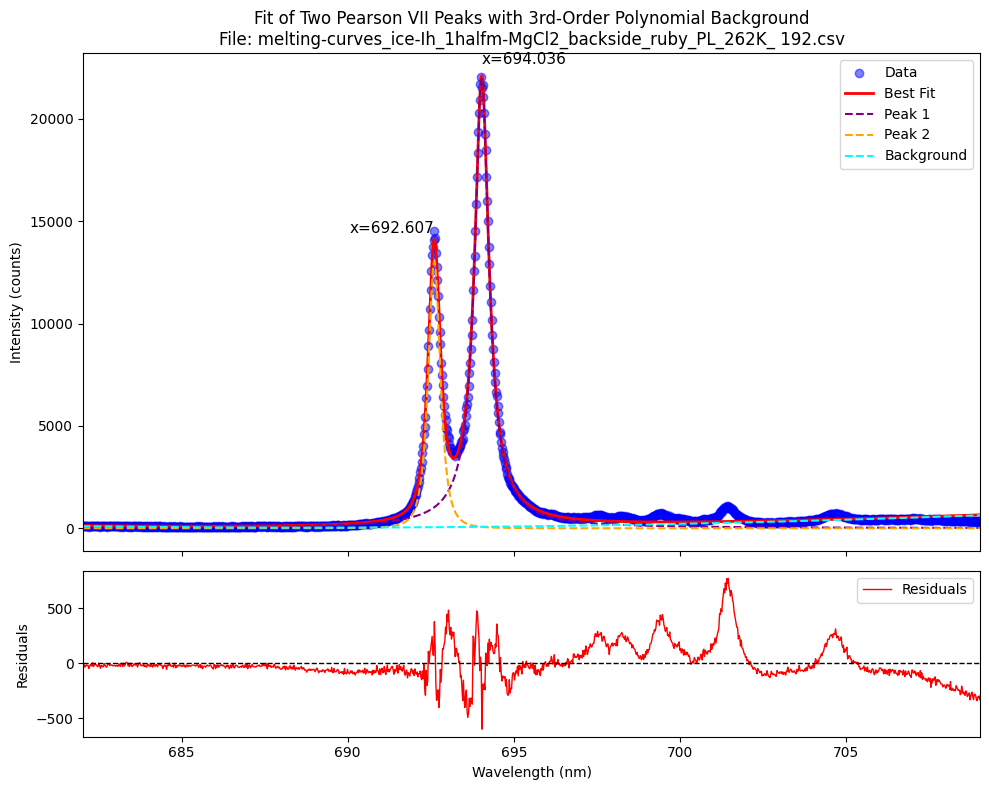

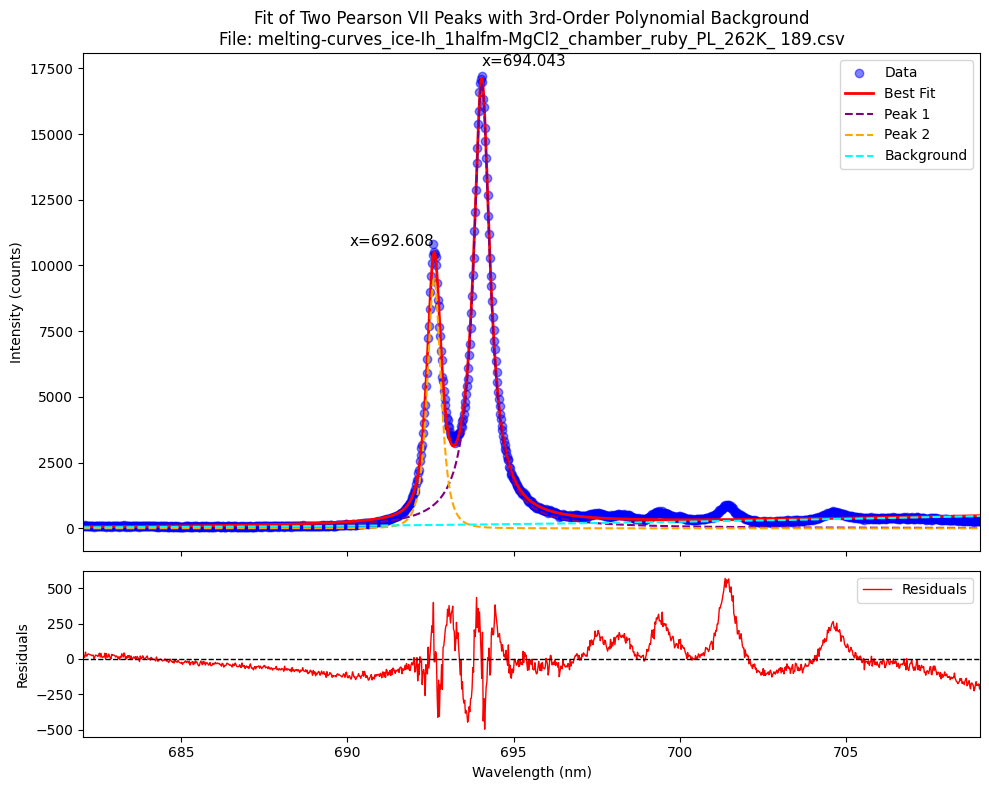

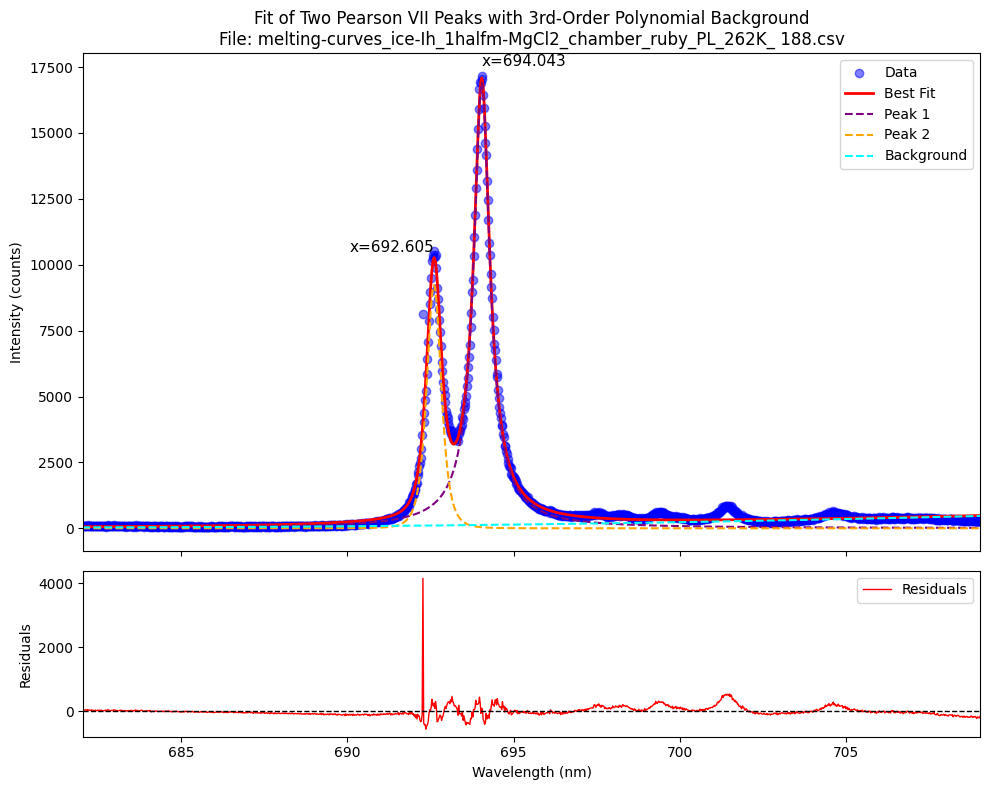

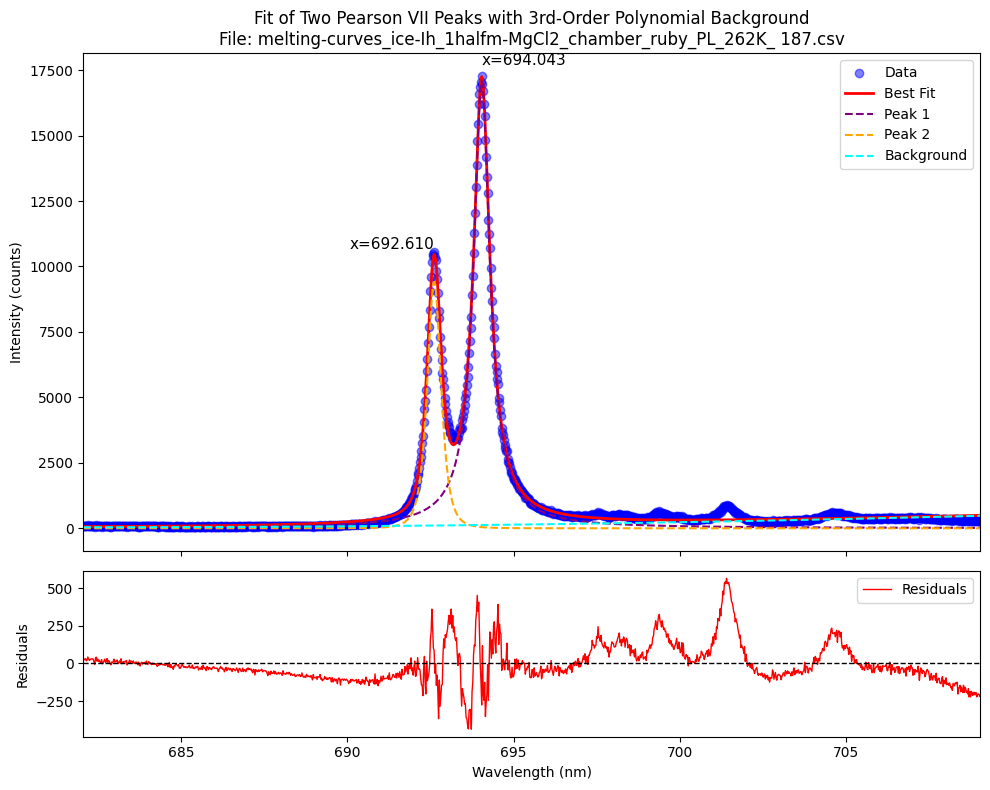

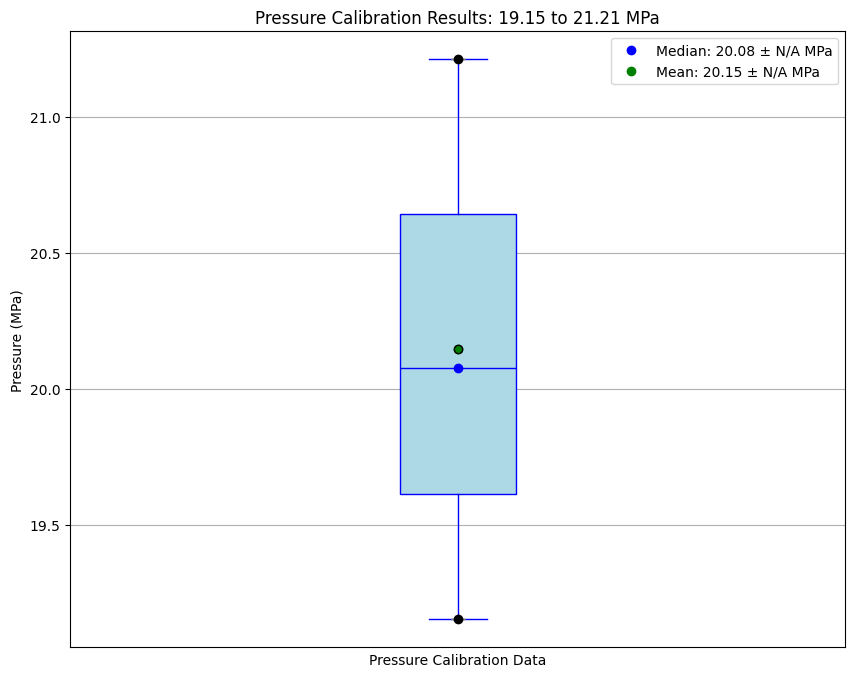

In [21]:
# Function to handle button clicks
def on_button_click(button_name):
    if button_name == "Upload Reference Data":
        upload_data('reference')
    elif button_name == "Upload High Pressure Data":
        upload_data('high_pressure')
    elif button_name == "Select Folder Path":
        select_folder_path()
    elif button_name == "Preview Fit":
        on_preview_button_clicked(None)
    elif button_name == "Fit and Save Data":
        on_save_button_clicked(None)
    elif button_name == "Input Experiment Information":
        input_experiment_information()
    elif button_name == "Preview Pressure Calibration Box Plot":
        on_preview_box_plot_button_clicked(None)
    elif button_name == "Create and Save Box Plot and Data Tables":
        on_save_box_plot_button_clicked(None)
    else:
        messagebox.showinfo("Info", f"{button_name} button clicked")

# Function to upload data
def upload_data(uploader_type):
    # Check if fitted_data_dict already has entries with keys including 'reference' or 'high_pressure'
    keys_to_delete = [key for key in fitted_data_dict.keys() if uploader_type in key]
    for key in keys_to_delete:
        del fitted_data_dict[key]

    file_paths = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
    if file_paths:
        files = []
        for file_path in file_paths:
            with open(file_path, 'rb') as f:
                files.append({'name': os.path.basename(file_path), 'content': f.read()})
        if uploader_type == 'reference':
            reference_uploader.value = tuple(files)
            on_upload_change({'new': reference_uploader.value}, uploader_type)
            messagebox.showinfo("Info", "Reference data uploaded successfully")
        elif uploader_type == 'high_pressure':
            high_pressure_uploader.value = tuple(files)
            on_upload_change({'new': high_pressure_uploader.value}, uploader_type)
            messagebox.showinfo("Info", "High pressure data uploaded successfully")

# Update the on_upload_change function
def on_upload_change(change, uploader_type):
    if change['new']:
        uploader = reference_uploader if uploader_type == 'reference' else high_pressure_uploader
        for uploaded_file in uploader.value:
            if 'content' in uploaded_file:
                data = pd.read_csv(io.BytesIO(uploaded_file['content']))
                
                # Extract x and y values
                x = data.iloc[:, 0].values
                y = data.iloc[:, 1].values

                # Check that x and y are properly imported
                print(f"{uploader_type.capitalize()} Data from {uploaded_file['name']}:")
                print(x)
                print(y)

# Prompt user to upload reference files
reference_uploader = type('obj', (object,), {'value': ()})

# Prompt user to upload high pressure files
high_pressure_uploader = type('obj', (object,), {'value': ()})

# Function to select folder path
def select_folder_path():
    global selected_folder_path
    selected_folder_path = filedialog.askdirectory()
    if selected_folder_path:
        messagebox.showinfo("Info", f"Selected folder: {selected_folder_path}")
    else:
        messagebox.showinfo("Info", "No folder selected. Please try again.")

def input_experiment_information():
    # Function to save temperature calibration information
    def save_temp_calib_info():
        temp_calib_info['Polynomial Temperature Calibration'] = perform_poly_temp_calib_var.get()
        temp_calib_info['Two-point Temperature Calibration'] = perform_temp_calibration_var.get()
        temp_calib_info['Freezing Point (K)'] = freezing_point_var.get()
        temp_calib_info['Boiling Point (K)'] = boiling_point_var.get()
        print("Temperature calibration information saved")

    def save_experiment_info():
        raw_temp = float(temperature_var.get())
        calibrated_temp = raw_temp  # Default to raw_temp if no calibration is performed

        if perform_temp_calibration_var.get():
            freezing_temp = float(freezing_point_var.get())
            boiling_temp = float(boiling_point_var.get())
            calibrated_temp = temperature_calibration(freezing_temp, boiling_temp, raw_temp)
        elif perform_poly_temp_calib_var.get():
            calibrated_temp = temp_corr_poly(raw_temp)

        experiment_info['Temperature (K)'] = calibrated_temp
        experiment_info['Laser Power (\u03BCW)'] = laser_power_var.get()
        experiment_info['Optical Diffraction (OD)'] = optical_diffraction_var.get()
        experiment_info['Spectrometer Grating (g/mm)'] = spectrometer_grating_var.get()
        experiment_info['Acquisition Time (ms)'] = acquisition_time_var.get()
        experiment_info['Experiment Type'] = experiment_type_var.get()

        save_temp_calib_info()
        messagebox.showinfo("Info", "Experiment information saved")

    info_window = tk.Toplevel()
    info_window.title("Experiment Information")

    temperature_var = tk.StringVar()
    laser_power_var = tk.StringVar()
    optical_diffraction_var = tk.StringVar()
    spectrometer_grating_var = tk.StringVar()
    acquisition_time_var = tk.StringVar()
    experiment_type_var = tk.StringVar()
    perform_temp_calibration_var = tk.BooleanVar()
    perform_poly_temp_calib_var = tk.BooleanVar()
    freezing_point_var = tk.StringVar()
    boiling_point_var = tk.StringVar()

    ttk.Label(info_window, text="Temperature (K):").grid(row=0, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=temperature_var).grid(row=0, column=1, sticky=tk.W)

    ttk.Label(info_window, text="Laser Power (\u03BCW):").grid(row=1, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=laser_power_var).grid(row=1, column=1, sticky=tk.W)

    ttk.Label(info_window, text="Optical Diffraction (OD):").grid(row=2, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=optical_diffraction_var).grid(row=2, column=1, sticky=tk.W)

    ttk.Label(info_window, text="Spectrometer Grating (g/mm):").grid(row=3, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=spectrometer_grating_var).grid(row=3, column=1, sticky=tk.W)

    ttk.Label(info_window, text="Acquisition Time (ms):").grid(row=4, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=acquisition_time_var).grid(row=4, column=1, sticky=tk.W)

    ttk.Label(info_window, text="Experiment Type:").grid(row=5, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=experiment_type_var).grid(row=5, column=1, sticky=tk.W)

    ttk.Checkbutton(info_window, text="Polynomial Temperature Calibration", variable=perform_poly_temp_calib_var).grid(row=6, column=0, columnspan=2, sticky=tk.W)
    ttk.Checkbutton(info_window, text="Two-point Temperature Calibration", variable=perform_temp_calibration_var).grid(row=7, column=0, columnspan=2, sticky=tk.W)

    ttk.Label(info_window, text="Freezing Point (K):").grid(row=8, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=freezing_point_var, state=tk.DISABLED).grid(row=8, column=1, sticky=tk.W)

    ttk.Label(info_window, text="Boiling Point (K):").grid(row=9, column=0, sticky=tk.W)
    ttk.Entry(info_window, textvariable=boiling_point_var, state=tk.DISABLED).grid(row=9, column=1, sticky=tk.W)

    ttk.Button(info_window, text="Save", command=save_experiment_info).grid(row=10, column=0, columnspan=2)


    def toggle_temp_calibration_fields(*args):
        # If polynomial calibration is selected, disable two-point calibration and entry fields
        if perform_poly_temp_calib_var.get():
            perform_temp_calibration_var.set(False)
            temp_calib_info['Two-point Temperature Calibration'] = False
            poly_checkbox.config(state=tk.NORMAL)
            two_point_checkbox.config(state=tk.DISABLED)
            freezing_point_entry.config(state=tk.DISABLED)
            boiling_point_entry.config(state=tk.DISABLED)
        # If two-point calibration is selected, disable polynomial calibration and enable entry fields
        elif perform_temp_calibration_var.get():
            perform_poly_temp_calib_var.set(False)
            temp_calib_info['Polynomial Temperature Calibration'] = False
            poly_checkbox.config(state=tk.DISABLED)
            two_point_checkbox.config(state=tk.NORMAL)
            freezing_point_entry.config(state=tk.NORMAL)
            boiling_point_entry.config(state=tk.NORMAL)
        # If neither is selected, enable both checkboxes and disable entry fields
        else:
            poly_checkbox.config(state=tk.NORMAL)
            two_point_checkbox.config(state=tk.NORMAL)
            freezing_point_entry.config(state=tk.DISABLED)
            boiling_point_entry.config(state=tk.DISABLED)

    # Replace the Checkbutton creation for polynomial calibration and two-point calibration with references
    poly_checkbox = ttk.Checkbutton(info_window, text="Polynomial Temperature Calibration", variable=perform_poly_temp_calib_var)
    poly_checkbox.grid(row=6, column=0, columnspan=2, sticky=tk.W)
    two_point_checkbox = ttk.Checkbutton(info_window, text="Two-point Temperature Calibration", variable=perform_temp_calibration_var)
    two_point_checkbox.grid(row=7, column=0, columnspan=2, sticky=tk.W)

    freezing_point_entry = ttk.Entry(info_window, textvariable=freezing_point_var, state=tk.DISABLED)
    boiling_point_entry = ttk.Entry(info_window, textvariable=boiling_point_var, state=tk.DISABLED)
    freezing_point_entry.grid(row=8, column=1, sticky=tk.W)
    boiling_point_entry.grid(row=9, column=1, sticky=tk.W)

    perform_poly_temp_calib_var.trace_add('write', toggle_temp_calibration_fields)
    perform_temp_calibration_var.trace_add('write', toggle_temp_calibration_fields)


# Function to create a new window for displaying plots or update the existing window
def create_plot_window(figures, window_title="Plot Window"):
    if not hasattr(create_plot_window, "plot_window") or not create_plot_window.plot_window.winfo_exists():
        create_plot_window.plot_window = tk.Toplevel()
        create_plot_window.plot_window.title(window_title)
        create_plot_window.canvas = None
        create_plot_window.toolbar = None
        create_plot_window.figures = figures
        create_plot_window.current_index = 0

        # Create a canvas for the plot
        create_plot_window.canvas = FigureCanvasTkAgg(figures[0], master=create_plot_window.plot_window)
        create_plot_window.canvas.draw()
        create_plot_window.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Create a toolbar for the plot
        create_plot_window.toolbar = NavigationToolbar2Tk(create_plot_window.canvas, create_plot_window.plot_window)
        create_plot_window.toolbar.update()
        create_plot_window.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Function to update the figure displayed on the canvas
        def update_figure(index):
            create_plot_window.canvas.figure = create_plot_window.figures[index]
            create_plot_window.canvas.draw()

        # Create buttons to flip through the figures
        button_frame = ttk.Frame(create_plot_window.plot_window)
        button_frame.pack(fill=tk.X)

        def on_prev_button_clicked():
            create_plot_window.current_index = (create_plot_window.current_index - 1) % len(create_plot_window.figures)
            update_figure(create_plot_window.current_index)

        def on_next_button_clicked():
            create_plot_window.current_index = (create_plot_window.current_index + 1) % len(create_plot_window.figures)
            update_figure(create_plot_window.current_index)

        prev_button = ttk.Button(button_frame, text="Previous", command=on_prev_button_clicked)
        prev_button.pack(side=tk.LEFT, padx=5, pady=5)

        next_button = ttk.Button(button_frame, text="Next", command=on_next_button_clicked)
        next_button.pack(side=tk.RIGHT, padx=5, pady=5)
    else:
        create_plot_window.figures.extend(figures)
        create_plot_window.current_index = len(create_plot_window.figures) - len(figures)
        create_plot_window.canvas.figure = create_plot_window.figures[create_plot_window.current_index]
        create_plot_window.canvas.draw()

# Define global variables to store figures
fig_reference = []
fig_high_pressure = []

# Define the callback function for processing all uploaded data files
def on_preview_button_clicked(b):
    global fig_reference, fig_high_pressure
    fig_reference = []
    fig_high_pressure = []

    for uploaded_file in reference_uploader.value:
        fig, result, fitted_data = process_file(uploaded_file)
        fig_reference.append(fig)
        result_reference.append(result)
        fitted_data_reference.append(fitted_data)

    for uploaded_file in high_pressure_uploader.value:
        fig, result, fitted_data = process_file(uploaded_file)
        fig_high_pressure.append(fig)
        result_high_pressure.append(result)
        fitted_data_high_pressure.append(fitted_data)

    # Rename keys for reference_uploader
    rename_keys(reference_uploader, 'reference')

    # Rename keys for high_pressure_uploader
    rename_keys(high_pressure_uploader, 'high_pressure')

    check_fit(fitted_data_dict)

    print("All uploaded files have been checked and fitted.")

    # Display the plots in the output window
    create_plot_window(fig_reference + fig_high_pressure)

    # Set the flag to True
    global preview_clicked
    preview_clicked = True

# Define the callback function for saving all data files
def on_save_button_clicked(b):
    global preview_clicked, fig_reference, fig_high_pressure
    if preview_clicked:
        print("Data has already been processed. Saving the results.")
        for i, uploaded_file in enumerate(reference_uploader.value):
            save_all_fitted(uploaded_file, fig_reference[i], result_reference[i], fitted_data_reference[i], 'reference')

        for i, uploaded_file in enumerate(high_pressure_uploader.value):
            save_all_fitted(uploaded_file, fig_high_pressure[i], result_high_pressure[i], fitted_data_high_pressure[i], 'high_pressure')
        print("All uploaded files have been processed and saved.")

        preview_clicked = False

    else:
        fig_reference = []
        fig_high_pressure = []

        print("Processing and saving the data.")
        for uploaded_file in reference_uploader.value:
            fig, result, fitted_data = process_file(uploaded_file)
            fig_reference.append(fig)
            result_reference.append(result)
            fitted_data_reference.append(fitted_data)

        for uploaded_file in high_pressure_uploader.value:
            fig, result, fitted_data = process_file(uploaded_file)
            fig_high_pressure.append(fig)
            result_high_pressure.append(result)
            fitted_data_high_pressure.append(fitted_data)

        # Rename keys for reference_uploader
        rename_keys(reference_uploader, 'reference')

        # Rename keys for high_pressure_uploader
        rename_keys(high_pressure_uploader, 'high_pressure')

        check_fit(fitted_data_dict)

        for i, uploaded_file in enumerate(reference_uploader.value):
            save_all_fitted(uploaded_file, fig_reference[i], result_reference[i], fitted_data_reference[i], 'reference')

        for i, uploaded_file in enumerate(high_pressure_uploader.value):
            save_all_fitted(uploaded_file, fig_high_pressure[i], result_high_pressure[i], fitted_data_high_pressure[i], 'high_pressure')
            
        print("All uploaded files have been processed and saved.")

        # Display the plots in the output window
        create_plot_window(fig_reference + fig_high_pressure)

# Define the callback function for previewing box plot and data tables
def on_preview_box_plot_button_clicked(b):
    fig_boxplot = bulk_pressure_calibration_boxplot(fitted_data_dict)
    create_plot_window([fig_boxplot], window_title="Box Plot")
    pressure_calibration_results = single_pressure_calibration(fitted_data_dict)

    # Display the average pressure range with min and max values
    pressure_values = [values['pressure_calibration_MPa'] for values in pressure_calibration_results.values()]
    min_pressure = min(pressure_values)
    max_pressure = max(pressure_values)
    print(f"\nPressure Range: {min_pressure:.2f} MPa to {max_pressure:.2f} MPa")

    # Set the flag to True
    global preview_boxplot_clicked
    preview_boxplot_clicked = True

# Define the callback function for creating and/or saving box plot and data tables
def on_save_box_plot_button_clicked(b):
    global preview_boxplot_clicked
    if preview_boxplot_clicked:
        print("Box plot has already been created. Saving the results.")
        data_tables = update_table_headers_and_add_filename_table(fitted_data_dict)
        box_plot_filenames = save_box_plot(boxplot_figures, selected_folder_path)
        save_data_tables_and_avg_pressure(data_tables, fitted_data_dict, selected_folder_path, box_plot_filenames)
        messagebox.showinfo("Info", "Box plot and data tables have been saved.")
        preview_boxplot_clicked = False
    else:
        fig_boxplot = bulk_pressure_calibration_boxplot(fitted_data_dict)
        create_plot_window([fig_boxplot], window_title="Box Plot")
        data_tables = update_table_headers_and_add_filename_table(fitted_data_dict)

        # Save the box plot and data tables
        box_plot_filenames = save_box_plot(boxplot_figures, selected_folder_path)
        save_data_tables_and_avg_pressure(data_tables, fitted_data_dict, selected_folder_path, box_plot_filenames)
        messagebox.showinfo("Info", "Box plot and data tables have been created and saved.")
        
# Function to create the main GUI window
def create_gui():
    root = tk.Tk()
    root.title("Ruby PL Data Processing")

    # Create a frame for the buttons
    button_frame = ttk.Frame(root, padding="10")
    button_frame.grid(row=0, column=0, sticky=(tk.W, tk.E))

    # Create buttons and add them to the frame
    buttons = [
        "Upload Reference Data",
        "Upload High Pressure Data",
        "Select Folder Path",
        "Preview Fit",
        "Fit and Save Data",
        "Input Experiment Information",
        "Preview Pressure Calibration Box Plot",
        "Create and Save Box Plot and Data Tables"
    ]

    for button_name in buttons:
        button = ttk.Button(button_frame, text=button_name, command=lambda bn=button_name: on_button_click(bn))
        button.pack(fill=tk.X, pady=5)

    # Create a frame for the output
    output_frame = ttk.Frame(root, padding="10")
    output_frame.grid(row=1, column=0, sticky=(tk.W, tk.E))

    # Create a text widget for displaying output
    output_text = tk.Text(output_frame, wrap="word", height=20, width=80)
    output_text.pack(fill=tk.BOTH, expand=True)

    # Redirect stdout to the text widget
    class StdoutRedirector:
        def __init__(self, text_widget):
            self.text_widget = text_widget

        def write(self, text):
            self.text_widget.insert(tk.END, text)
            self.text_widget.see(tk.END)

        def flush(self):
            pass

    sys.stdout = StdoutRedirector(output_text)

    root.mainloop()

# Call the function to create the GUI
create_gui()